<a href="https://colab.research.google.com/github/alwanfa/neural-network-exploration/blob/main/DUDL_data_featureAugmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COURSE: A deep understanding of deep learning
## SECTION: More on data
### LECTURE: Data feature augmentation
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202401

In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

import numpy as np

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Create and prepare the data

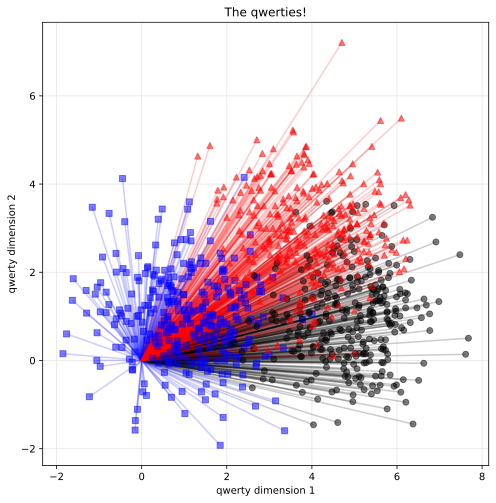

In [4]:
# create data

nPerClust = 300
blur = 1

A = [ 1, 1 ]
B = [ 5, 1 ]
C = [ 4, 3 ]

# generate data
a = [ A[0]+np.random.randn(nPerClust)*blur , A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur , B[1]+np.random.randn(nPerClust)*blur ]
c = [ C[0]+np.random.randn(nPerClust)*blur , C[1]+np.random.randn(nPerClust)*blur ]

# true labels
labels_np = np.hstack((  np.zeros((nPerClust)),
                         np.ones( (nPerClust)),
                       1+np.ones( (nPerClust))  ))

# concatanate into a matrix
data_np = np.hstack((a,b,c)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long() # note: "long" format for CCE

# show the data
fig = plt.figure(figsize=(8,8))
# draw distance to origin
color = 'bkr'
for i in range(len(data)):
  plt.plot([0,data[i,0]],[0,data[i,1]],color=color[labels[i]],alpha=.2)

plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs',alpha=.5)
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko',alpha=.5)
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'r^',alpha=.5)

plt.grid(color=[.9,.9,.9])
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

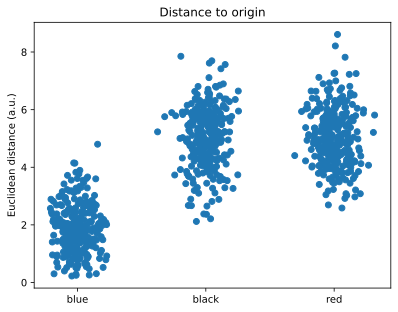

In [7]:
# compute Euclidean distance to the origin
dist2orig = torch.sqrt( data[:,0]**2 + data[:,1]**2 )

plt.plot(labels+torch.randn(900)/10,dist2orig,'o')
plt.xticks([0,1,2],labels=['blue','black','red'])
plt.ylabel('Euclidean distance (a.u.)')
plt.title('Distance to origin')
plt.show()

In [12]:
dist2orig.view(len(data),1).shape

torch.Size([900, 1])

In [8]:
# And add that to the data matrix
dataAug = torch.cat((data,dist2orig.view(len(data),1)),axis=1)

# check data sizes
print(data.shape)
print(dataAug.shape)
print(' ')

# look at some of the data
print(dataAug)

torch.Size([900, 2])
torch.Size([900, 3])
 
tensor([[ 1.0470e+00,  9.5437e-01,  1.4167e+00],
        [-1.0541e+00,  1.1719e-03,  1.0541e+00],
        [ 1.2203e-01,  4.5893e-01,  4.7488e-01],
        ...,
        [ 4.5057e+00,  2.1103e+00,  4.9754e+00],
        [ 3.9744e+00,  1.4223e+00,  4.2213e+00],
        [ 4.4922e+00,  2.6370e+00,  5.2090e+00]])


In [13]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataAug, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

# finally, translate into dataloader objects
batchsize    = 16
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

# Create the model

In [30]:
# create a class for the model
def createTheQwertyNet(useExtraFeature=False):

  class qwertyNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      if useExtraFeature:
        self.input = nn.Linear(3,8)
      else:
        self.input = nn.Linear(2,8)

      ### hidden layer
      self.fc1 = nn.Linear(8,8)

      ### output layer
      self.output = nn.Linear(8,3)

    # forward pass
    def forward(self,x):

      # by request, only use XY features
      # print(x.shape) # comment out during training!
      if not useExtraFeature:
        x = x[:,:2]
      # print(x.shape) # comment out during training!

      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      return self.output(x)

  # create the model instance
  net = qwertyNet()

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.0001)

  return net,lossfun,optimizer

In [23]:
# test the model

print('Using augmented feature:')
net = createTheQwertyNet(True)[0]
net(next(iter(train_loader))[0]);

print('\nNot using augmented feature:')
net = createTheQwertyNet(False)[0]
net(next(iter(train_loader))[0]);


Using augmented feature:
torch.Size([16, 3])
torch.Size([16, 3])

Not using augmented feature:
torch.Size([16, 3])
torch.Size([16, 2])


In [16]:
# a function that trains the model

def function2trainTheModel(useExtraFeature=False):

  # number of epochs
  numepochs = 200

  # create a new model
  net,lossfun,optimizer = createTheQwertyNet(useExtraFeature)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )
  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

# A function that plots the results

In [37]:
#
def plotTheResults():

  # compute accuracy over entire dataset (train+test)
  yHat = net(dataAug)
  predictions = torch.argmax(yHat,axis=1)
  accuracy = (predictions == labels).float()

  # and accuracy by group
  accuracyByGroup = np.zeros(3)
  for i in range(3):
    accuracyByGroup[i] = 100*torch.mean(accuracy[labels==i])


  # create the figure
  fig,ax = plt.subplots(2,2,figsize=(10,6))

  # plot the loss function
  ax[0,0].plot(losses.detach())
  ax[0,0].set_ylabel('Loss')
  ax[0,0].set_xlabel('epoch')
  ax[0,0].set_title('Losses')

  # plot the accuracy functions
  ax[0,1].plot(trainAcc,label='Train')
  ax[0,1].plot(testAcc,label='Test')
  ax[0,1].set_ylabel('Accuracy (%)')
  ax[0,1].set_xlabel('Epoch')
  ax[0,1].set_title('Accuracy')
  ax[0,1].legend()

  # plot overall accuracy by group
  ax[1,0].bar(range(3),accuracyByGroup, color=["blue", "black", "red"])
  ax[1,0].set_ylim([np.min(accuracyByGroup)-5,np.max(accuracyByGroup)+5])
  ax[1,0].set_xticks([0,1,2])
  ax[1,0].set_xlabel('Group')
  ax[1,0].set_ylabel('Accuracy (%)')
  ax[1,0].set_title('Accuracy by group')

  # scatterplot of correct and incorrect labeled data
  colorShapes = [ 'bs','ko','r^' ] # data markers
  for i in range(3):
    # plot all data points
    ax[1,1].plot(dataAug[labels==i,0],dataAug[labels==i,1],colorShapes[i],
                 alpha=.3,label=f'Group {i}')

    # cross-out the incorrect ones
    idxErr = (accuracy==0) & (labels==i)
    ax[1,1].plot(dataAug[idxErr,0],dataAug[idxErr,1],'rx')

  ax[1,1].set_title('All groups')
  ax[1,1].set_xlabel('qwerty dimension 1')
  ax[1,1].set_ylabel('qwerty dimension 2')
  ax[1,1].legend()

  plt.tight_layout()
  plt.show()

# Test the model with and without the additional feature

Final accuracy: 91.11%


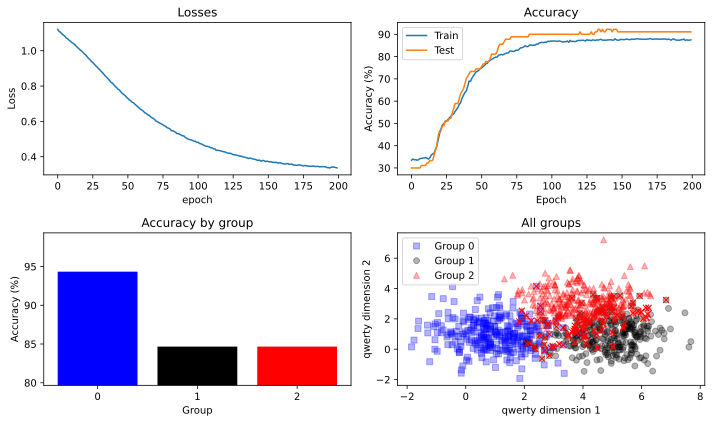

In [38]:
# run the model and visualize the results
trainAcc,testAcc,losses,net = function2trainTheModel(False)
print('Final accuracy: %.2f%%' %testAcc[-1].item())
plotTheResults()

Final accuracy: 91.11%


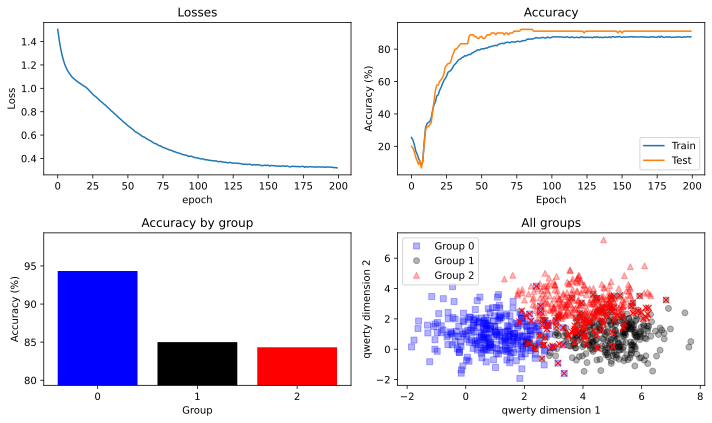

In [39]:
# run the model and visualize the results
trainAcc,testAcc,losses,net = function2trainTheModel(True)
print('Final accuracy: %.2f%%' %testAcc[-1].item())
plotTheResults()

# Run the experiment!

In [33]:
# Run the experiment multiple times and do a t-test!
# (takes ~3 mins)

finalacc2 = np.zeros(10)
finalacc3 = np.zeros(10)

for i in range(10):
  finalacc2[i] = function2trainTheModel(False)[1][-1]
  finalacc3[i] = function2trainTheModel(True)[1][-1]

# show the numbers
print( np.round(np.vstack((finalacc2,finalacc3)).T,2) )

# run the t-test and print the results
from scipy import stats
t,p = stats.ttest_ind(finalacc3,finalacc2)
print('\n\nt=%.2f, p=%.2f' %(t,p))

[[90.   91.11]
 [90.   88.89]
 [91.11 90.  ]
 [90.   91.11]
 [91.11 90.  ]
 [88.89 90.  ]
 [91.11 90.  ]
 [91.11 90.  ]
 [91.11 90.  ]
 [90.   91.11]]


t=-0.67, p=0.51


# Additional explorations

In [ ]:
# 1) Add code to the "distance-to-origin" plot (top of the script) so the color and shape of the dots matches those
#    used in the previous qwerties plot. Also, change the colors of the bars in the barplots to match the qwerties. v
#
# 2) If you increase the learning rate, or increase the number of epochs, or use Adam instead of SGD, you'll find that
#    both datasets lead to equally good -- and high -- performance. Based on the graph of the data, do you think it's
#    even possible to reach 100% accuracy? What does this tell you about ceiling effects in DL? v
#